# Problem definition

Sales forecasting is a very common problem faced by many companies. Given a history of sales of a certain product we would like to predict the demand of that product for a time window in the future. This is useful as it allows companies and industries to plan their workload and reduce waste of resources. This problem is a common example of time series forecasting and there are many approaches to tackle it.

Today we will learn a bit more about this with a practical example: the [Kaggle Predict Future Sales dataset](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/). This challenge aims to predict future sales of different products for the next month in different shops of a retail chain. In this notebook we do not aim at solving this challenge, rather, we will explore some concepts of time series forecasting that could be used to solve such problem.

# Exploring the dataset

First we need to download the whole dataset and extract it to a `data` folder in the root of this notebook path.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact_manual
plt.style.use('ggplot')
%matplotlib inline

In [2]:
#load sales and rename columns to ease understanding
dtype = {'date_block_number':np.uint16, 'shop_id':np.uint32, 'item_id':np.uint32, 'item_cnt_day':np.float32}
sales = pd.read_csv('data/sales_train.csv', dtype=dtype) \
          .rename(columns={'date_block_num': 'month', 'item_cnt_day':'sold'})

In [3]:
sales.head()

,date,month,shop_id,item_id,item_price,sold
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


As we can see, we have daily records for each shop and item. Note that some of the `sold` values are negative because they include returns.

Firstly, since we are interested in estimating the monthly sales, we will aggregate the dataset by month using the handy `month` feature, which ranges from 0 (representing January 2013) to 33 (October 2015). We will group the sales by the shop and item ids. The aggregation will sum all `sold` fields during the month for each product and shop, and average the item_price (it is likely to change from month to month).

In [4]:
gsales = sales.groupby(['shop_id','item_id','month']).agg({'item_price':np.mean, 'sold':np.sum})

In [5]:
gsales[:20]

item_price  sold
shop_id item_id month                  
0       30      1           265.0  31.0
        31      1           434.0  11.0
        32      0           221.0   6.0
                1           221.0  10.0
        33      0           347.0   3.0
                1           347.0   3.0
        35      0           247.0   1.0
                1           247.0  14.0
        36      1           357.0   1.0
        40      1           127.0   1.0
        42      1           127.0   1.0
        43      0           221.0   1.0
        49      1           127.0   2.0
        51      0           128.5   2.0
                1           127.0   3.0
        57      1           167.0   1.0
        59      1           110.0   1.0
        61      0           195.0   1.0
        75      0            76.0   1.0
        85      1           190.0   1.0

We can now observe that for the first shop many items only have selling records for the first two months. We would like to investigate how this varies for different products across all 60 shops.

In [6]:
@interact_manual(shop_id = (0,59,1))
def plot_product_record_frequency(shop_id):
    count_months = gsales.reset_index().groupby(['shop_id','item_id']).size()[shop_id]
    plt.bar(count_months.keys(), count_months)
    plt.xlabel('product_id')
    plt.ylabel('Num months available')

interactive(children=(IntSlider(value=29, description='shop_id', max=59), Button(description='Run Interact', s…

However, this interactive visualisation will not work unless you have a notebook running, so we will plot the sales frequency for some of the stores below:

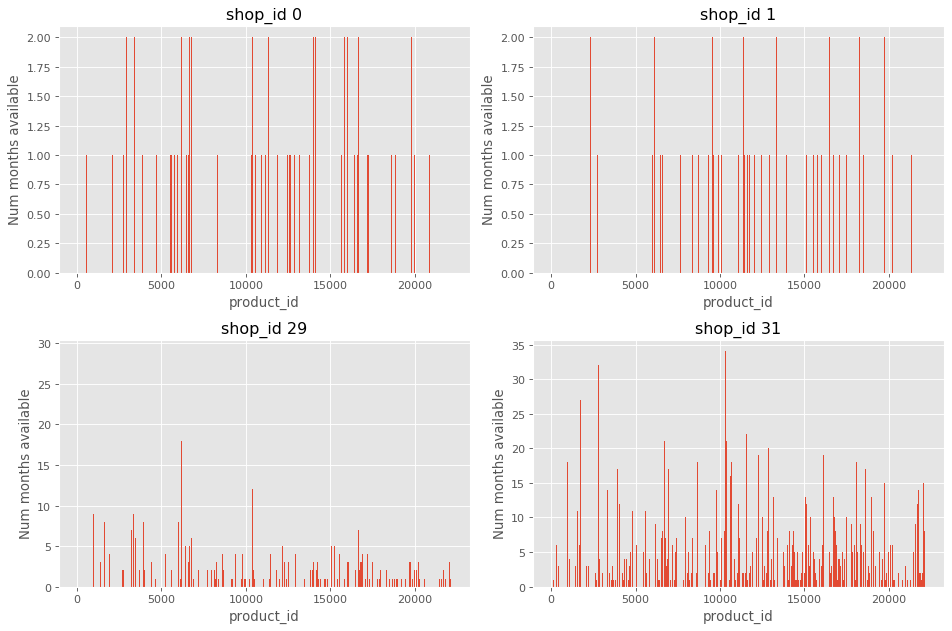

In [7]:
def plot_product_record_frequency(shop_id):
    count_months = gsales.reset_index().groupby(['shop_id','item_id']).size()[shop_id]
    plt.bar(count_months.keys(), count_months)
    plt.xlabel('product_id')
    plt.ylabel('Num months available')
    plt.title(f'shop_id {shop_id}')
    
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')    
for i, shop_id in enumerate([0,1,29,31]):
    plt.subplot(2,2,i+1)
    plot_product_record_frequency(shop_id)
plt.tight_layout()

We can observe that some shops have a very limited record of sales, e.g. shop 0 and 1. On the other hand, shop 29 and 31 have a considerable number of items with a record above 10 weeks.

Perhaps we should look into the shops with the larger number of sales, which we can inspect by observing the distribution of `shop_id`:

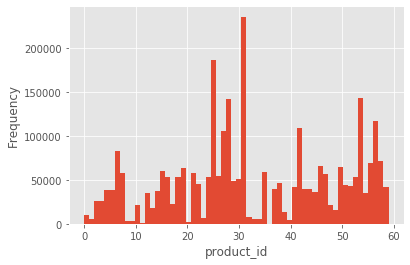

In [8]:
sales['shop_id'].plot.hist(bins=60)
plt.xlabel('product_id');

If we observe the previous histogram for the number of weeks of records for each product of a given shop, we will observe indeed that the shop 31 has a comprehensive number of products with a significant history of sales.

Considering the behaviour of multiple shops introduce complexity steaming from this biased distribution of sales. Some shops will have very little preior information about their sales, so it would be difficult to make a good prediction of sales in these shops. For this reason we will neglect different shops and instead try to estimate a new volume of sales for all products in the whole supermarket chain. So, we modify our aggregated sales DataFrame `gsales` accordingly:

In [9]:
gsales = sales.groupby(['item_id','month']).agg({'item_price':np.mean, 'sold':np.sum})

We can also observe what is the number of months available for each product sale history in this chain-wide collection:

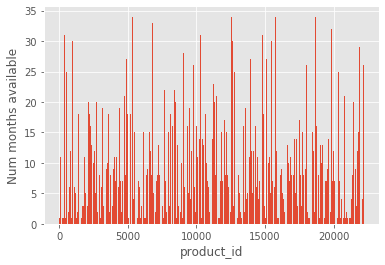

In [10]:
count_months = gsales.reset_index().groupby(['item_id']).size()
plt.bar(count_months.keys(),count_months);
plt.xlabel('product_id')
plt.ylabel('Num months available');

Although in a real forecast scenario we would like to have a good prediction of sales even when the history for a given product is minimal, in this example we will focus on products with full history for all 34 months.

In [11]:
productsIdx = count_months[count_months == 34].index.values
selected_sales = gsales.loc[productsIdx]
productsIdx.shape

(523,)

We obtained 523 unique products that have a selling history for all of the 33 months. An example of the first 60 items are below:

In [12]:
selected_sales[:60]

item_price   sold
item_id month                   
32      0      338.110349  299.0
        1      337.771930  208.0
        2      343.794702  178.0
        3      341.888889   97.0
        4      347.000000   66.0
        5      342.070886   79.0
        6      345.951190   87.0
        7      340.172727   72.0
        8      340.017544   59.0
        9      184.592593   58.0
        10     144.316456   81.0
        11     147.994444   89.0
        12     144.710526   84.0
        13     144.066667   48.0
        14     149.000000   44.0
        15     143.714286   30.0
        16     149.000000   26.0
        17     149.000000   26.0
        18     130.500000   12.0
        19     148.991176   34.0
        20     144.771429   37.0
        21     148.991667   37.0
        22     146.060714   29.0
        23     149.000000   40.0
        24     145.572727   42.0
        25     146.387333   32.0
        26     146.869167   40.0
        27     149.000000   20.0
        28     149.000000   20.0
        29     149.000000   26.0
        30     149.000000   21.0
        31     148.714286   30.0
        32     149.000000   19.0
        33     149.000000   22.0
33      0      488.517241   61.0
        1      484.170732   39.0
        2      490.870968   32.0
        3      489.500000   16.0
        4      499.000000   12.0
        5      205.046512   44.0
        6      195.439130   46.0
        7      197.277778   35.0
        8      198.052381   43.0
        9      195.915152   33.0
        10     194.866667   15.0
        11     195.900000   42.0
        12     197.487805   42.0
        13     196.862069   29.0
        14     197.673333   30.0
        15     199.000000   18.0
        16     196.658824   17.0
        17     199.000000   21.0
        18     199.000000   14.0
        19     197.756250   17.0
        20     199.000000   13.0
        21     199.000000   14.0
        22     195.460000   20.0
        23     199.000000   21.0
        24     199.000000   19.0
        25     199.000000   26.0

We have explored the dataset and observed some items of interest. The next step is using this information to predict the number of sales over another month

# Time Series Analysis

Firstly, let's observe what the sales time series look like for some of the products:

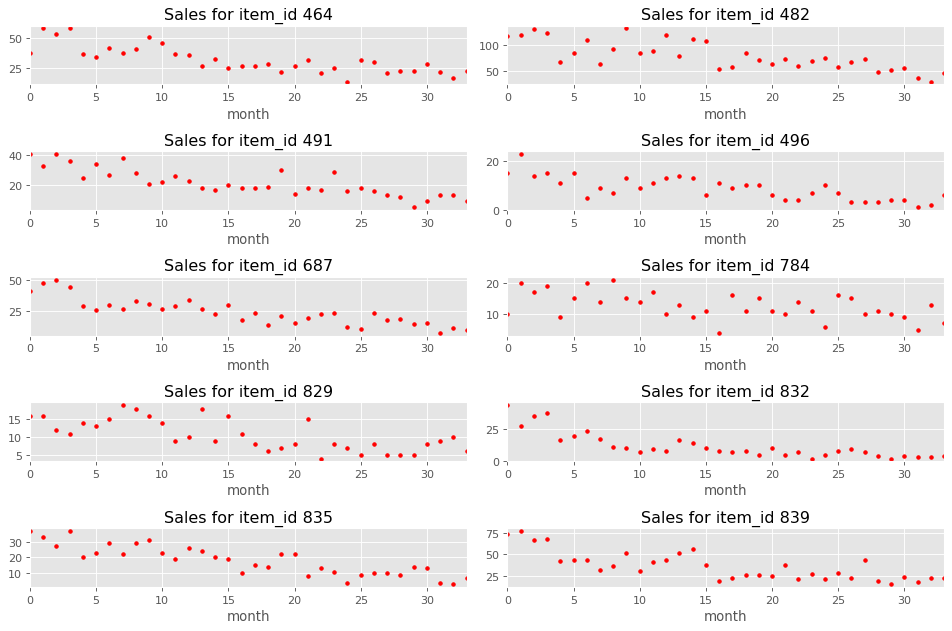

In [13]:
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
for i, idx in enumerate(selected_sales.index.get_level_values(0).unique()[10:20]):
    plt.subplot(5,2,i+1)
    selected_sales.loc[idx]['sold'].plot(style='r.')
    plt.title(f'Sales for item_id {idx}')
    plt.tight_layout()

We can see some seasonality patterns in the plotted data, so we will decompose one of the observed time series into a trend and seasonal effects with a multiplicative model $Y(t) = T(t) S(t) r(t)$ where $T(t)$ is the trend, $S(t)$ the the seasonal component and $r(t)$ is the residual.

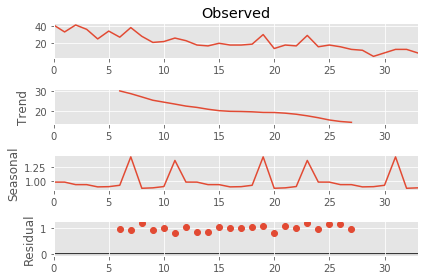

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
item_id = 491
sales_product = selected_sales.loc[item_id]['sold'].values
dec = seasonal_decompose(sales_product, model='multiplicative', period=12)
dec.plot();

We observed that the residual values tend to be close to 1, which means the observed series has a good fit to the seasonal and trend decomposition. 

This analysis shows that the observed time series have a trend that decreases throughout the months, and a seasonal component, which seems to peak around August and December. This decomposition could be exploited to improve prediction results, however we would require a model that incorporate this seasonality pattern. 

# Time series forecasting

In this section we will evaluate two different models for time series forecasting: Auto Regressive Integrated Moving Average (ARIMA) and Gaussian Process (GP).

Firstly, we train the models on each product time series up to month 30. Then, we evaluate for the remaining of months available across all selected products. Our metric will be the Root Mean Squared Error (RMSE) computed with the predicted and ground-truth time series. Please note that this metric is the same as used in the original challenge.

### Gaussian Processes

GPs are non-parametric models that can represent a posterior over functions. They work well when we do not wish to impose strong assumptions on the generative data process. For a more detailed explanation of GPs, please visit this [distill post](https://distill.pub/2019/visual-exploration-gaussian-processes/).

We chose experimented with a multitude of kernels, the best performing were the simpler ones: RBF and Matern. Note that the parameters of these kernels are optimised (within the given bounds) during the `fit` process. Please note that we normalise the target sales by the maximum value such that the target number of sales ranges from [0,1].

First, let's observe what happens using a single item_id and extrapolating between the months:


In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, Matern, ExpSineSquared, ConstantKernel

kernel = RBF()
gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=2, alpha = 1e-5, normalize_y=True)

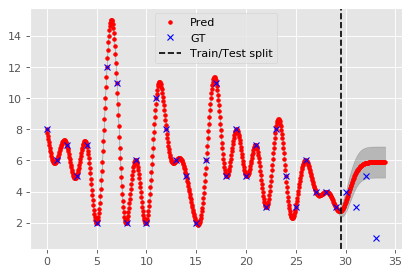

In [16]:
item_id = 53
X = np.arange(0,34,0.05).reshape(-1,1)
Y = selected_sales['sold'][item_id].values.reshape(-1,1)
ymax = Y.max()

gp.fit(np.arange(30).reshape(-1,1), Y[:30]/ymax)
Y_pred, Y_pred_std = gp.predict(X, return_std=True)
Y_pred = Y_pred.reshape(-1)*ymax

fig=plt.figure(figsize=(6, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(X, Y_pred, 'r.', label='Pred')
plt.fill_between(X.reshape(-1), Y_pred - Y_pred_std, Y_pred + Y_pred_std, alpha=0.2, color='k');
plt.plot(np.arange(34), Y, 'bx', label='GT')
plt.axvline(29.5, 0, 1, color='black', ls='--', label='Train/Test split')
plt.legend();

Now we will create a GP for each item_id time series within our selected sales:

In [17]:
Y_preds_gp = []
Y_gts = []
for item_id in selected_sales.index.get_level_values(0).unique():
    X = np.arange(34).reshape(-1,1)
    X_train, X_test = X[:30], X[30:]
    
    Y = selected_sales['sold'][item_id].values.reshape(-1,1)
    Y_train, Y_test = Y[:30], Y[30:]
    ymax = Y_train.max()
    
    kernel = RBF()
    gp = GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=0, alpha = 1e-2, normalize_y=True)
    gp.fit(X_train, Y_train/ymax)
    ypred = gp.predict(X_test)*ymax
    
    Y_preds_gp.append(ypred)
    Y_gts.append(Y_test)
    
Y_preds_gp = np.concatenate(Y_preds_gp, axis=0)
Y_gts = np.concatenate(Y_gts, axis=0)

### ARIMA

Auto Regressive Integrated Moving Average models the time series using
$$Y(t) = \alpha + \beta_1 Y(t-1) + \beta_2 Y(t-2) + \dots + \beta_p Y(t-p) + \gamma_1 \epsilon(t-1) + \gamma_2 \epsilon(t-2) + \dots + \gamma_q \epsilon(t-q) + \epsilon(t)$$
where $\epsilon(t)$ is the residual from the ground-truth and estimated value. The parameters $\alpha, \beta, \gamma$ are optimised during fitting. The hyper-parameters $p,d,q$ correspond to the order of the process, **i.e.** how many terms of previous timestamps, how many previous error terms and how many times to differentiate the time series until it becomes stationary.

For simplicity, we assume our time-series are stationary and use $p=1$, $q=0$, $d=0$

Again, let's start by visualising a single time-series and the resulting ARIMA prediction.

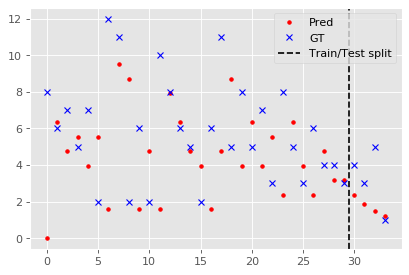

In [18]:
from statsmodels.tsa.arima_model import ARIMA

item_id = 53
Y = selected_sales['sold'][item_id].values.reshape(-1,1)

model = ARIMA(Y[:30], order=(1,0,0)).fit(trend='nc')
Y_pred = model.predict(0,33)

fig=plt.figure(figsize=(6, 4), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(X, Y_pred, 'r.', label='Pred')
plt.plot(np.arange(34), Y, 'bx', label='GT')
plt.axvline(29.5, 0, 1, color='black', ls='--', label='Train/Test split')
plt.legend();

We may also observe the approximate distribution of the residuals:

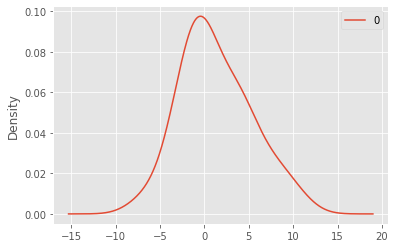

In [19]:
residuals = pd.DataFrame(model.resid)
residuals.plot.kde();

Next, we forecast for all items in the selected sales for the remaining 4 months (30,31,32,33):

In [20]:
Y_preds_arima = []
for item_id in selected_sales.index.get_level_values(0).unique():  
    Y = selected_sales['sold'][item_id].values.reshape(-1,1)
    Y_train, Y_test = Y[:30], Y[30:]
    
    ypred = gp.predict(X_test)
    model = ARIMA(Y[:30], order=(1,0,0)).fit(trend='nc')
    ypred = model.predict(30,33)
    
    Y_preds_arima.append(ypred)
    
Y_preds_arima = np.concatenate(Y_preds_arima, axis=0)

### Evaluation

Finally computing the RMSE metric between predictions (of GP and ARIMA) and ground-truths for all selected items for the remaining 4 months (30,31,32,33):

In [21]:
from sklearn.metrics import mean_squared_error as mse
rmse_gp = mse(Y_gts, Y_preds_gp, squared=False)
rmse_arima = mse(Y_gts, Y_preds_arima, squared=False)
print(f"RMSE GP {rmse_gp} \nRMSE ARIMA {rmse_arima}")

RMSE GP 58.58414105624866 
RMSE ARIMA 50.27118697649368


Knowingly, forecasting 4 months into the future would be difficult. Instead we could consider only the 30th month forecast of all items:

In [22]:
rmse_gp = mse(Y_gts[::4], Y_preds_gp[::4], squared=False)
rmse_arima = mse(Y_gts[::4], Y_preds_arima[::4], squared=False)
print(f"RMSE GP {rmse_gp} \nRMSE ARIMA {rmse_arima}")

RMSE GP 28.212626816686967 
RMSE ARIMA 7.92125195871772


# Conclusion

We observed that the ARIMA model performed better under the RMSE metric for the presented dataset. Still, both RMSE are quite high and should be reduced if the model were to be used in practice.

To further improve the results and to account to a more realistic setting where some items or shops will have a limited history of sales, we must work on feature engineering to overcome these limitations. Example of features that could be exploited include, but are not limited to:
 
1. Shop-specific aggregated stats (mean num of sales)
2. City-specific aggregated stats (mean num of sales, pop. size, etc).
3. Item categories aggregated stats (mean num of sales for a specific product category)
4. Item price and price variations

# Further reading

If you are interested in time series forecasting I highly recommend the above blog posts:

1. https://www.linkedin.com/pulse/how-use-machine-learning-time-series-forecasting-vegard-flovik-phd
2. https://towardsdatascience.com/an-overview-of-time-series-forecasting-models-a2fa7a358fcb